In [5]:
import numpy as np
import matplotlib.pyplot as plt


def load_from_csv(file):
    """file: filename
       return: 
           features: np.array[ncases, nfeatures]
           descriptions: list[nfeatures]
           correct_answers: np.array[ncases]
    """
    raw_data = np.genfromtxt(file, delimiter=',', names=True)
    raw_descriptions = list(raw_data.dtype.names)
    raw_data = np.array(list(map(list, raw_data)))
    
    features = raw_data[:, 1:-1]
    descriptions = raw_descriptions[1:-1]
    correct_answers = raw_data[:,-1]  
    return features, descriptions, correct_answers


def save_to_csv(descriptions, features, correct_answers, file):
    """descriptions: list[nfeatures]
       features: np.array[ncases, nfeatures]
       correct_answers: np.array[ncases]
       file: filename
    """
    f = open(file, 'wt')
    descriptions = ["ID"] + descriptions + ["default.payment.next.month"]
    print(','.join(descriptions), file=f)
    for i in range(features.shape[0]):
        print("%i,%s,%f" % (i+1, ','.join(map(str, features[i])), correct_answers[i]), file=f)
    f.close()
 
    
def add_feature(features, descriptions, new_feature, new_description):
    """
        features: np.array[ncases, nfeatures]
        descriptions: list[nfeatures]
        new_feature: np.array[ncases]
        new_description: str
        return:
            new_features: np.array[ncases, nfeatures+1]
            new_descriptions: list[nfeatures+1]
            
    """
    new_features, new_descriptions = add_features(features, descriptions, new_feature[:,np.newaxis], [new_description])
    return new_features, new_descriptions


def add_features(features, descriptions, new_features, new_descriptions):
    """
        features: np.array[ncases, nfeatures]
        descriptions: list[nfeatures]
        new_features: np.array[ncases, nnewfeatures]
        new_descriptions: list[nnewfeatures]
        return:
            new_new_features: np.array[ncases, nfeatures+nnewfeatures]
            new_new_descriptions: list[nfeatures+nnewfeatures]
    """
    new_new_features = np.concatenate([features, new_features],1)
    new_new_descriptions = descriptions + new_descriptions
    return new_new_features, new_new_descriptions
    
def add_one_hot_encoded_feature(features, descriptions, feature, description):
    """
        features: np.array[ncases, nfeatures]
        descriptions: list[nfeatures]
        feature: np.array[ncases]
        description: str
        return:
            new_features: np.array[ncases, nfeatures+1]
            new_descriptions: list[nfeatures+1]
    """
    hot_features, hot_descriptions = one_hot_encoded_feature(feature, description)
    new_features = np.concatenate([features, hot_features], 1)
    new_descriptions = descriptions + hot_descriptions
    return new_features, new_descriptions

def one_hot_encoded_feature(feature, description):
    """
        feature: np.array[ncases]
        description: str
        return:
            new_features: np.array[ncases,n_one_hot_encoded_features]
            new_descriptions: list[n_one_hot_encoded_features]
    """
    unique_values = sorted(set(feature)) #сколько столбцов
    new_descriptions = []
    for i in range(len(unique_values)):
        new_descriptions.append(description + " = " + str(unique_values[i]))
    feature = feature[:,np.newaxis]
    unique_values = np.array(unique_values)
    unique_values = unique_values[np.newaxis,:]      
    return (feature == unique_values).astype(np.float), new_descriptions

def make_uniform_borders(feature, c_diapasones):
    """
    feature: np.array[ncases]
    c_diapasones: int
    return:
        uniform_borders: list[c_diapasones-1]
    """
    max_diap = np.max(feature)
    min_diap = np.min(feature)
    diap = max_diap - min_diap
    step = diap / c_diapasones##20
    uniform_borders=[]
    for i in range(1, c_diapasones):
        uniform_borders.append(min_diap + step * i)   
    return uniform_borders

def make_quantile_borders(feature, c_diapasones):
    """
    feature: np.array[ncases]
    c_diapasones: int
    return:
        quantile_borders: list[c_diapasones-1]
    """
    quantile_numbers = make_uniform_borders([0, 1], c_diapasones)
    feature = sorted(feature)
    quantile_borders = []
    for i in range(0, c_diapasones - 1):
        quantile_borders.append(get_quantile_element(feature, quantile_numbers[i]))
    return quantile_borders

def get_quantile_element(sorted_feature, quantile_number):
    """
    sorted_feature: sorted list[ncases]
    quantile_number: int
    return:
        quantile_element: int
    """
    return sorted_feature[int(quantile_number * len(sorted_feature))]
    
def quantificator(feature, description, borders):
    """
    feature: np.array[ncases]
    description: str
    borders: list[nborders]
    return:
        new_features: np.array[ncases,nborders+1]
        new_descriptions: list[nborders+1]
    """
    borders = sorted(borders)
    f1 = feature < borders[0]
    d1 = description + " < %f" %borders[0]
    
    fi = []
    di = []
    for i in range(0, len(borders)-1):
        fi.append(np.logical_and(feature >= borders[i], feature < borders[i+1]))
        di.append(("%f <="%borders[i]) + description + " < %f" %borders[i+1])
    flast = feature >= borders[-1]
    dlast = ("%f <="%borders[-1]) + description
    
    new_features = np.stack([f1] + fi + [flast], axis=1)
    new_descriptions = [d1] + di + [dlast]
    
    return new_features.astype(np.float32), new_descriptions

def add_qr_feature(features, descriptions, feature, description, c_diapasones):
    """
    features: np.array[ncases, nfeatures]
    descriptions: list[nfeatures]
    feature: np.array[ncases]
    description: str
    c_diapasones: int
    return:
        new_features: np.array[ncases,2*c_diapasones-1]
        new_descriptions: list[2*c_diapasones-1]
    
    """
    uniform_borders = []#make_uniform_borders(feature, c_diapasones)
    quantile_borders = make_quantile_borders(feature, c_diapasones)
    all_borders = uniform_borders + quantile_borders
    new_features, new_descriptions = quantificator(feature, description, all_borders)  
    new_features, new_descriptions = add_features(features, descriptions, new_features, new_descriptions)
    return new_features, new_descriptions

def analyze(features, descriptions):
    std_dev = np.apply_along_axis(np.std, 0, features)
    mean = np.apply_along_axis(np.mean, 0, features)
    for i in range(features.shape[1]):
        print('%r:======================================================================' %(i))
        print(descriptions[i])
        print("std_dev", std_dev[i])
        print("mean", mean[i])
        print("min", np.min(features[:,i]))
        print("max", np.max(features[:,i]))
        n, bins, patches = plt.hist(features[:,i], 20, normed=0, facecolor='red',)
        plt.show()

LIMIT_BAL = 0
SEX = 1
EDUCATION = 2
MARRIAGE = 3
AGE = 4
PAY_0 = 5 
PAY_2 = 6 
PAY_3 = 7
PAY_4 = 8
PAY_5 = 9
PAY_6 = 10
BILL_AMT1 = 11
BILL_AMT2 = 12
BILL_AMT3 = 13
BILL_AMT4 = 14
BILL_AMT5 = 15
BILL_AMT6 = 16
PAY_AMT1 = 17
PAY_AMT2 = 18
PAY_AMT3 = 19
PAY_AMT4 = 20
PAY_AMT5 = 21
PAY_AMT6 = 22

In [6]:
np.set_printoptions(300000)
features, descriptions, correct_answers = load_from_csv('ccard_dev.csv')

# Feature 0.
nf = np.ones((features.shape[0], 1))
nd = ["1"]

# Feature 1.
f = features[:,LIMIT_BAL]
f = np.log(f)
f = (f - np.min(f))/(max(f) - np.min(f))
#print(f)
nf, nd = add_feature(nf, nd, f, "LOG(%s)"%descriptions[LIMIT_BAL])

# Feature 2.
nf, nd = add_one_hot_encoded_feature(nf, nd, features[:,SEX], descriptions[SEX]) 

# Feature 3.
f = features[:, EDUCATION]
f[f>3] = 0
nf, nd = add_one_hot_encoded_feature(nf, nd, f, descriptions[EDUCATION])

# Feature 4.
f = features[:, MARRIAGE]
f[f==3] = 0
nf, nd = add_one_hot_encoded_feature(nf, nd, f, descriptions[MARRIAGE]) 

# Feature 5.
nf, nd = add_qr_feature(nf, nd, features[:, AGE], descriptions[AGE], 5)

# Feature 6.
for i in range(PAY_0, PAY_6+1):
    f = features[:, i]
    f[f>3]=3   
    nf, nd = add_one_hot_encoded_feature(nf, nd, f, descriptions[i]) 
    
# Feature 7.
for i in range(BILL_AMT1, BILL_AMT6+1):
    nf, nd = add_qr_feature(nf, nd, features[:, i], descriptions[i], 5)
    
# Feature 8.
for i in range(BILL_AMT1, BILL_AMT6+1):
    f = features[:, i] / features[:, LIMIT_BAL]
    d = descriptions[i] + "/" + descriptions[LIMIT_BAL]
    nf, nd = add_qr_feature(nf, nd, f, d, 5)

# Feature 9.
for i in range(PAY_AMT1, PAY_AMT6+1):
    nf, nd = add_qr_feature(nf, nd, features[:, i], descriptions[i], 5)

# Feature 12.
for i in range(PAY_AMT1, PAY_AMT6+1):
    f = features[:, i] / features[:, LIMIT_BAL]
    d = descriptions[i] + "/" + descriptions[LIMIT_BAL]
    nf, nd = add_qr_feature(nf, nd, f, d, 5)
    
# Feature Scaling
 

# Debug printing.
print(nf.shape)
print(np.sum(nf==0,axis=0))
print(nd)
print("ok")

(2999, 168)
[   0   75 1592 1407 2934 1998 1664 2401 2960 1531 1507 2480 2421 2315
 2443 2337 2671 2472 1521 2631 2754 2946 2582 2422 1431 2997 2618 2945
 2555 2429 1433 2625 2954 2514 2444 1419 2652 2967 2501 2461 1294 2773
 2967 2459 2467 1328 2773 2969 2400 2399 2399 2399 2399 2400 2399 2399
 2399 2399 2400 2399 2399 2399 2399 2401 2398 2399 2399 2399 2400 2399
 2399 2399 2399 2401 2398 2399 2399 2399 2400 2399 2399 2399 2399 2400
 2399 2399 2399 2399 2400 2399 2399 2399 2399 2400 2399 2399 2399 2399
 2400 2399 2399 2399 2399 2400 2400 2398 2399 2399 2400 2399 2494 2307
 2396 2400 2399 2455 2346 2396 2400 2399 2402 2405 2390 2999 1847 2353
 2458 2339 2999 1820 2380 2455 2342 2999 1849 2354 2462 2332 2400 2402
 2407 2388 2399 2400 2399 2399 2399 2399 2400 2403 2395 2399 2399 2999
 1822 2377 2399 2399 2999 1800 2399 2399 2399 2999 1802 2397 2400 2398]
['1', 'LOG(110000)', '1 = 1.0', '1 = 2.0', '1_1 = 0.0', '1_1 = 1.0', '1_1 = 2.0', '1_1 = 3.0', '2 = 0.0', '2 = 1.0', '2 = 2.0', '30 < 2

0:======================================================================
110000
std_dev 129496.39760782855
mean 169358.45281760587
min 10000.0
max 780000.0


/home/thinklab/.local/share/virtualenvs/classifier-I88LoDwm/local/lib/python3.7/site-packages/ipykernel_launcher.py:191: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


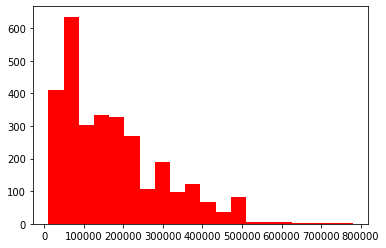

1:======================================================================
1
std_dev 0.49904776469013484
mean 1.5308436145381794
min 1.0
max 2.0


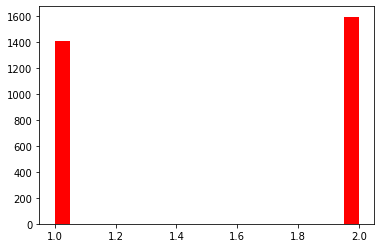

2:======================================================================
1_1
std_dev 0.7669985609481057
mean 1.822274091363788
min 0.0
max 3.0


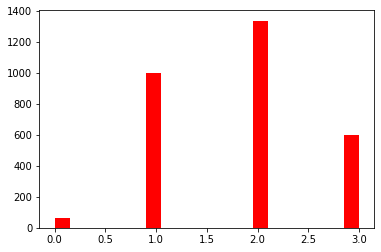

3:======================================================================
2
std_dev 0.5251364197137094
mean 1.4844948316105369
min 0.0
max 2.0


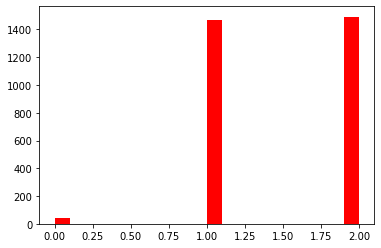

4:======================================================================
30
std_dev 9.051283128386304
mean 36.3187729243081
min 21.0
max 74.0


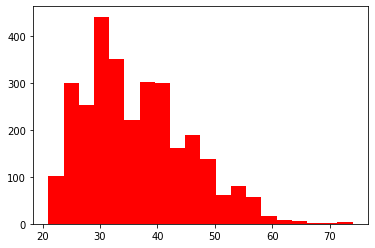

5:======================================================================
0
std_dev 1.1039369366994602
mean -0.05535178392797599
min -2.0
max 3.0


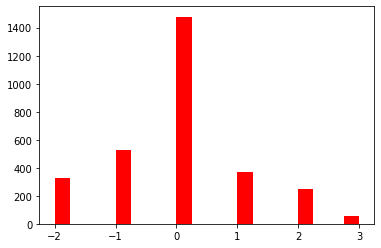

6:======================================================================
0_1
std_dev 1.1803896025542346
mean -0.16172057352450817
min -2.0
max 3.0


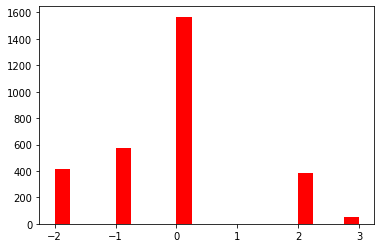

7:======================================================================
0_2
std_dev 1.174469283890232
mean -0.19173057685895298
min -2.0
max 3.0


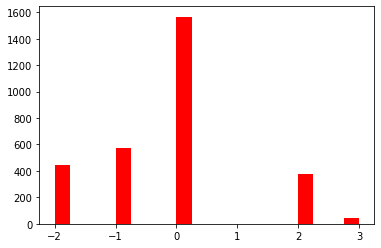

8:======================================================================
0_3
std_dev 1.1535735328217591
mean -0.245081693897966
min -2.0
max 3.0


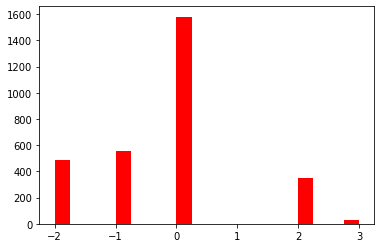

9:======================================================================
2_1
std_dev 1.0644184007242992
mean -0.32877625875291766
min -2.0
max 3.0


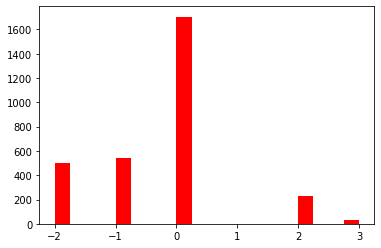

10:======================================================================
2_2
std_dev 1.0778684541789296
mean -0.3567855951983995
min -2.0
max 3.0


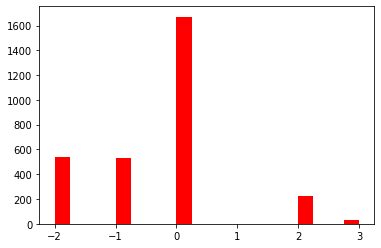

11:======================================================================
60290
std_dev 77654.93532803355
mean 52318.65421807269
min -11545.0
max 746814.0


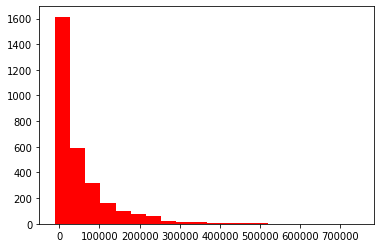

12:======================================================================
61688
std_dev 74233.25668941985
mean 50128.160053351115
min -17710.0
max 586825.0


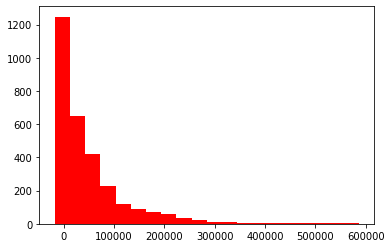

13:======================================================================
63100
std_dev 72098.64860321199
mean 47828.75291763921
min -46127.0
max 572677.0


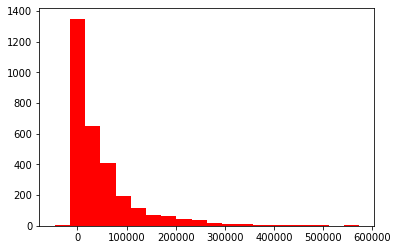

14:======================================================================
70391
std_dev 67021.89450145251
mean 44740.93397799267
min -50616.0
max 504929.0


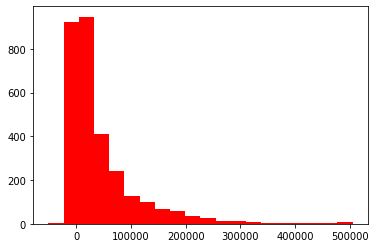

15:======================================================================
68661
std_dev 62176.04547793523
mean 40127.454484828275
min -53007.0
max 587067.0


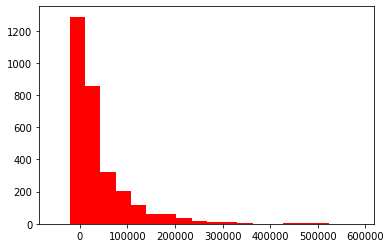

16:======================================================================
77511
std_dev 61444.509624354854
mean 38848.090696898966
min -94625.0
max 498316.0


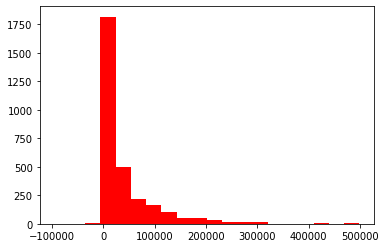

17:======================================================================
3000
std_dev 25979.825413278835
mean 6485.735911970657
min 0.0
max 873552.0


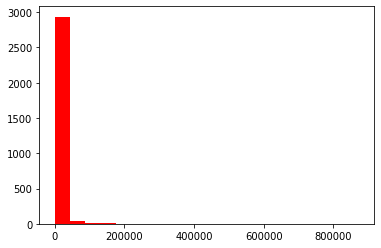

18:======================================================================
3000_1
std_dev 34807.75689980486
mean 6318.353451150383
min 0.0
max 1227082.0


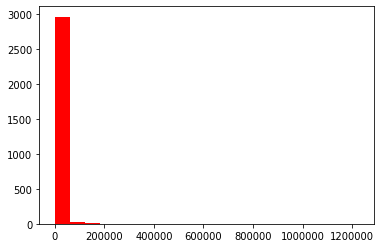

19:======================================================================
9000
std_dev 25446.466848978962
mean 6139.913304434812
min 0.0
max 889043.0


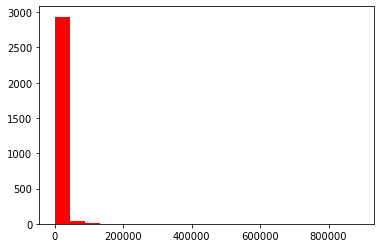

20:======================================================================
0_4
std_dev 18457.421077794443
mean 4983.404134711571
min 0.0
max 621000.0


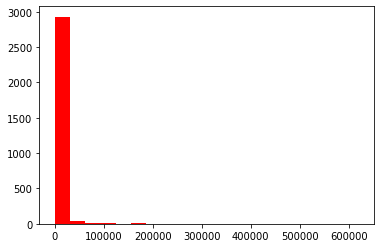

21:======================================================================
10000
std_dev 17027.371463514246
mean 4896.114704901634
min 0.0
max 426529.0


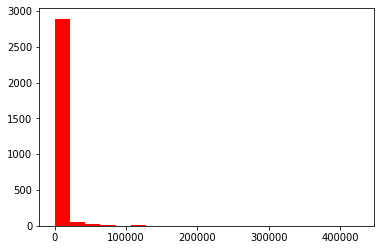

22:======================================================================
3000_2
std_dev 20150.098043618626
mean 5590.103034344782
min 0.0
max 443001.0


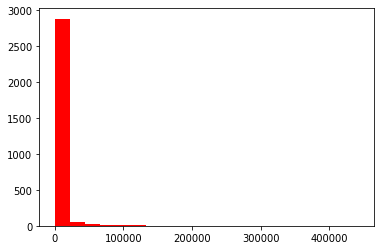

In [7]:
# Analyze
analyze(features, descriptions)

0:======================================================================
1
std_dev 0.0
mean 1.0
min 1.0
max 1.0


/home/thinklab/.local/share/virtualenvs/classifier-I88LoDwm/local/lib/python3.7/site-packages/ipykernel_launcher.py:191: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


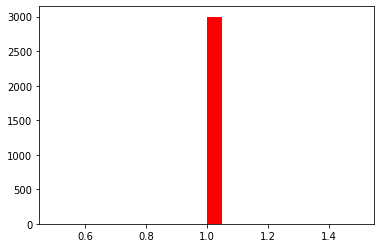

1:======================================================================
LOG(110000)
std_dev 0.21944999780879174
mean 0.5650225795900732
min 0.0
max 1.0


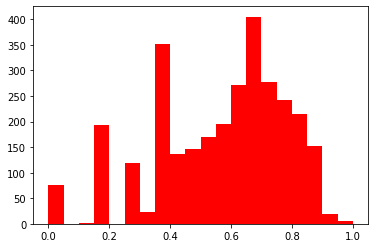

2:======================================================================
1 = 1.0
std_dev 0.49904776469013484
mean 0.4691563854618206
min 0.0
max 1.0


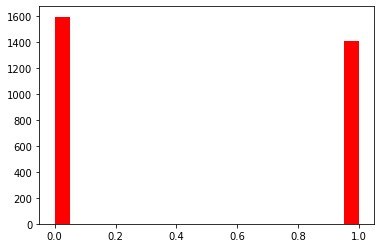

3:======================================================================
1 = 2.0
std_dev 0.49904776469013484
mean 0.5308436145381794
min 0.0
max 1.0


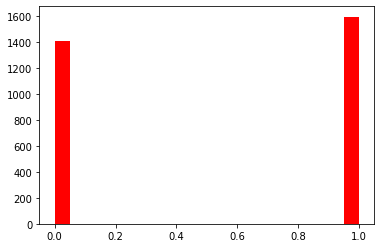

4:======================================================================
1_1 = 0.0
std_dev 0.14561639239158677
mean 0.021673891297099034
min 0.0
max 1.0


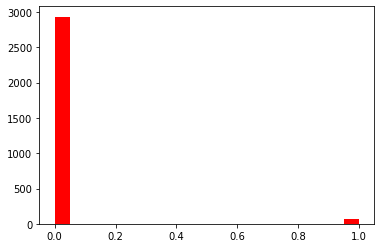

5:======================================================================
1_1 = 1.0
std_dev 0.47156147224612777
mean 0.33377792597532513
min 0.0
max 1.0


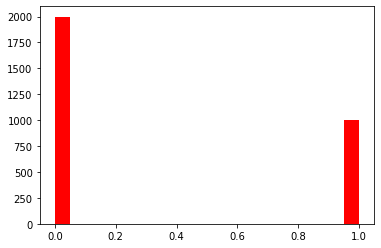

6:======================================================================
1_1 = 2.0
std_dev 0.4969821929304062
mean 0.4451483827942648
min 0.0
max 1.0


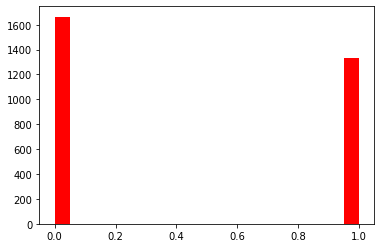

7:======================================================================
1_1 = 3.0
std_dev 0.3995491455626787
mean 0.1993997999333111
min 0.0
max 1.0


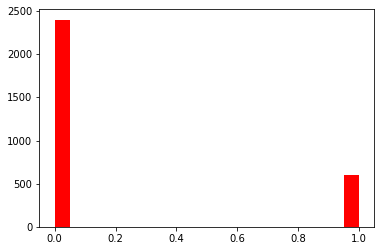

8:======================================================================
2 = 0.0
std_dev 0.11329263901610893
mean 0.01300433477825942
min 0.0
max 1.0


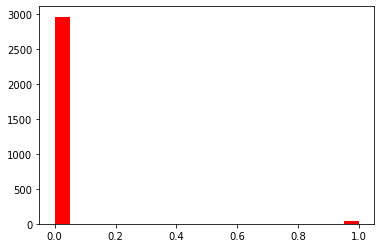

9:======================================================================
2 = 1.0
std_dev 0.49988966428926457
mean 0.4894964988329443
min 0.0
max 1.0


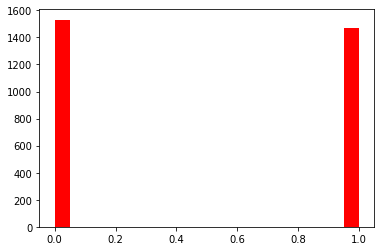

10:======================================================================
2 = 2.0
std_dev 0.499993745792134
mean 0.49749916638879627
min 0.0
max 1.0


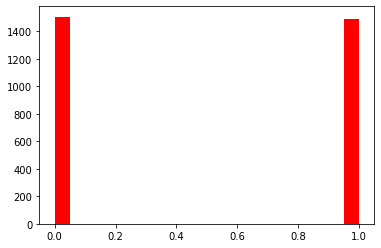

11:======================================================================
30 < 28.000000
std_dev 0.3782971361877626
mean 0.17305768589529844
min 0.0
max 1.0


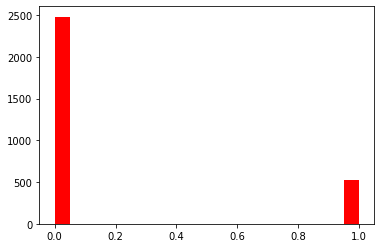

12:======================================================================
28.000000 <=30 < 32.000000
std_dev 0.3944435403413827
mean 0.19273091030343448
min 0.0
max 1.0


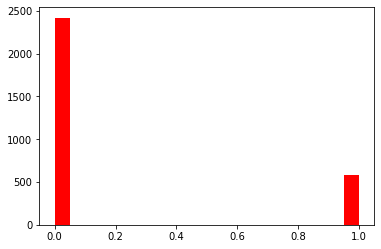

13:======================================================================
32.000000 <=30 < 38.000000
std_dev 0.4195918874407321
mean 0.2280760253417806
min 0.0
max 1.0


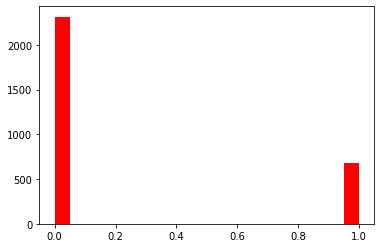

14:======================================================================
38.000000 <=30 < 44.000000
std_dev 0.38861777731929675
mean 0.18539513171057018
min 0.0
max 1.0


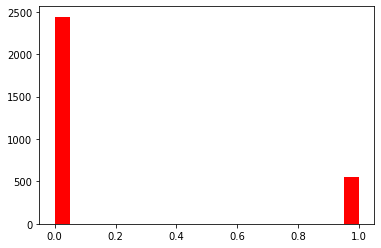

15:======================================================================
44.000000 <=30
std_dev 0.4147456934244692
mean 0.22074024674891632
min 0.0
max 1.0


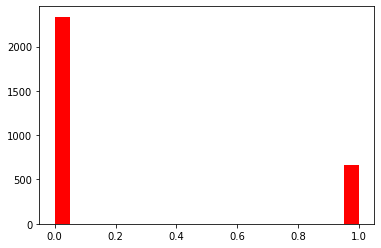

16:======================================================================
0 = -2.0
std_dev 0.3121026096985564
mean 0.10936978992997666
min 0.0
max 1.0


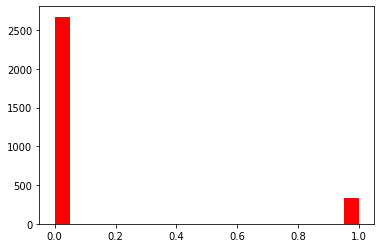

17:======================================================================
0 = -1.0
std_dev 0.3805862335399429
mean 0.17572524174724907
min 0.0
max 1.0


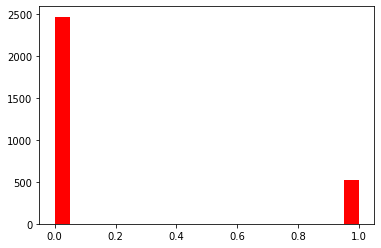

18:======================================================================
0 = 0.0
std_dev 0.4999486019892647
mean 0.4928309436478826
min 0.0
max 1.0


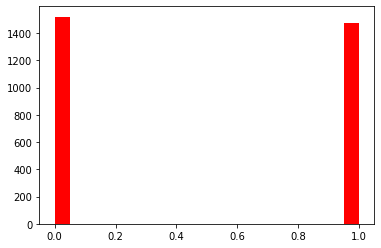

19:======================================================================
0 = 1.0
std_dev 0.32810123689690285
mean 0.12270756918972991
min 0.0
max 1.0


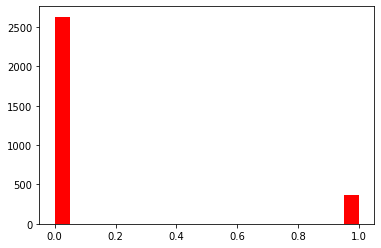

20:======================================================================
0 = 2.0
std_dev 0.273897800285273
mean 0.08169389796598867
min 0.0
max 1.0


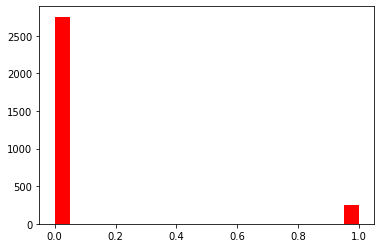

21:======================================================================
0 = 3.0
std_dev 0.13175825678075956
mean 0.017672557519173057
min 0.0
max 1.0


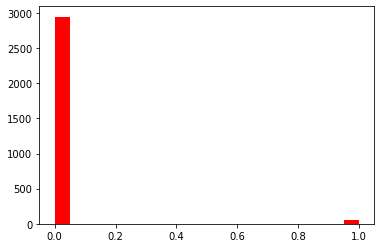

22:======================================================================
0_1 = -2.0
std_dev 0.3459948867730044
mean 0.13904634878292765
min 0.0
max 1.0


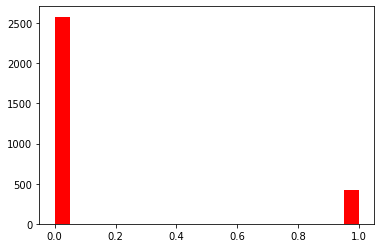

23:======================================================================
0_1 = -1.0
std_dev 0.3941835625279621
mean 0.19239746582194064
min 0.0
max 1.0


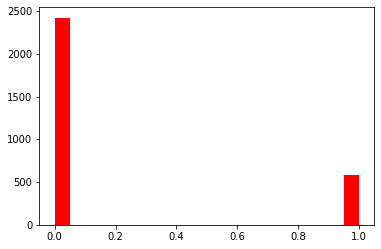

24:======================================================================
0_1 = 0.0
std_dev 0.49947801867644837
mean 0.5228409469823274
min 0.0
max 1.0


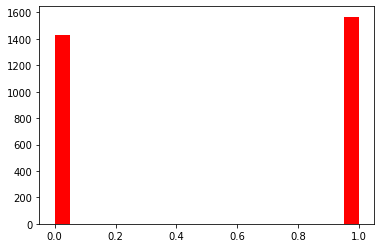

25:======================================================================
0_1 = 1.0
std_dev 0.025815580994792815
mean 0.0006668889629876625
min 0.0
max 1.0


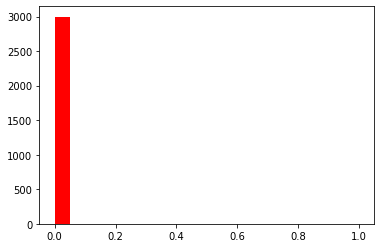

26:======================================================================
0_1 = 2.0
std_dev 0.3330204038850461
mean 0.12704234744914972
min 0.0
max 1.0


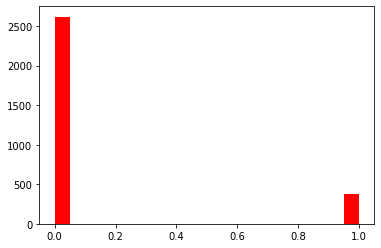

27:======================================================================
0_1 = 3.0
std_dev 0.13297287652983547
mean 0.01800600200066689
min 0.0
max 1.0


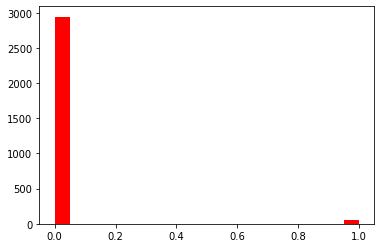

28:======================================================================
0_2 = -2.0
std_dev 0.355148898086443
mean 0.1480493497832611
min 0.0
max 1.0


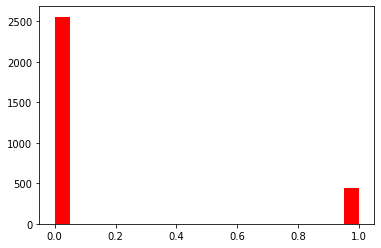

29:======================================================================
0_2 = -1.0
std_dev 0.3923509599148872
mean 0.19006335445148384
min 0.0
max 1.0


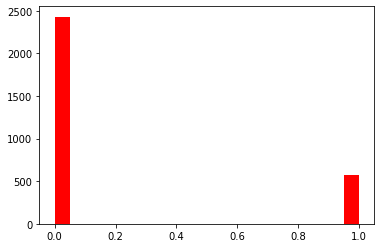

30:======================================================================
0_2 = 0.0
std_dev 0.49950806915499874
mean 0.5221740580193398
min 0.0
max 1.0


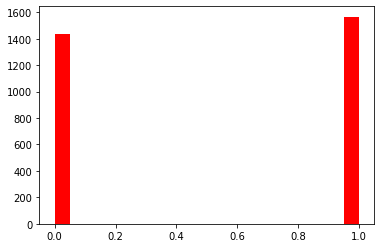

31:======================================================================
0_2 = 2.0
std_dev 0.3303877902296541
mean 0.1247082360786929
min 0.0
max 1.0


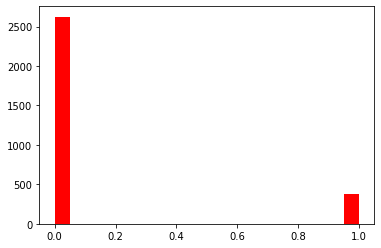

32:======================================================================
0_2 = 3.0
std_dev 0.12157241295700706
mean 0.015005001667222408
min 0.0
max 1.0


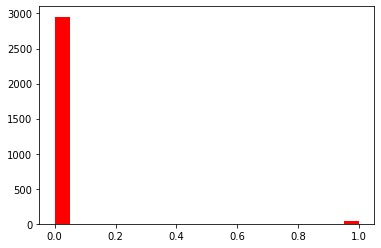

33:======================================================================
0_3 = -2.0
std_dev 0.36819428244258806
mean 0.16172057352450817
min 0.0
max 1.0


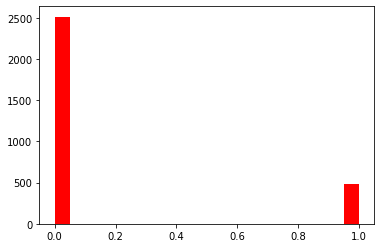

34:======================================================================
0_3 = -1.0
std_dev 0.38834760093118115
mean 0.18506168722907637
min 0.0
max 1.0


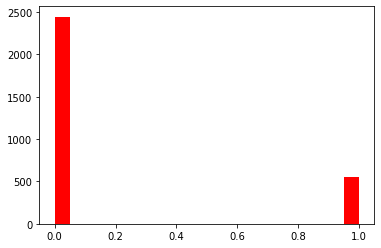

35:======================================================================
0_3 = 0.0
std_dev 0.4992789720823297
mean 0.5268422807602534
min 0.0
max 1.0


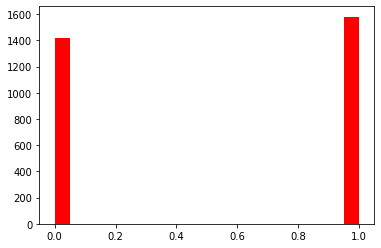

36:======================================================================
0_3 = 2.0
std_dev 0.3198711203810388
mean 0.11570523507835945
min 0.0
max 1.0


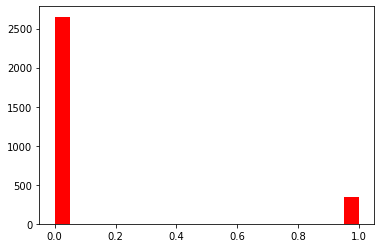

37:======================================================================
0_3 = 3.0
std_dev 0.10274419565226148
mean 0.0106702234078026
min 0.0
max 1.0


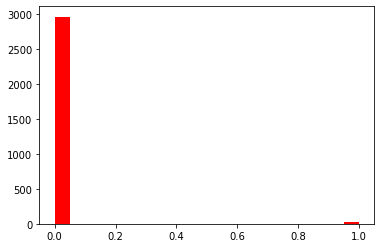

38:======================================================================
2_1 = -2.0
std_dev 0.3721303157871499
mean 0.16605535178392797
min 0.0
max 1.0


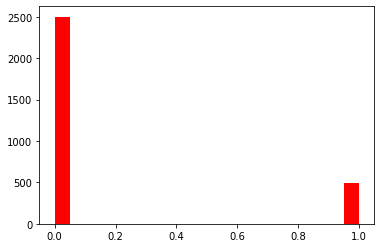

39:======================================================================
2_1 = -1.0
std_dev 0.3836811639604241
mean 0.17939313104368124
min 0.0
max 1.0


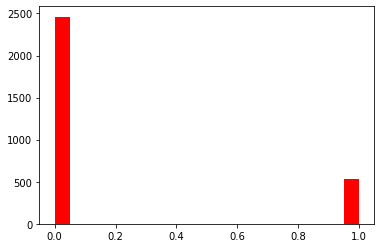

40:======================================================================
2_1 = 0.0
std_dev 0.4952823641808323
mean 0.5685228409469824
min 0.0
max 1.0


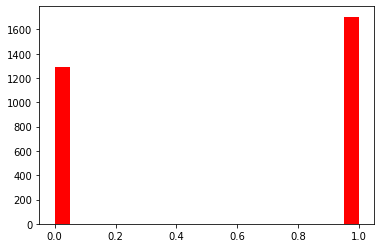

41:======================================================================
2_1 = 2.0
std_dev 0.26396885499343015
mean 0.07535845281760586
min 0.0
max 1.0


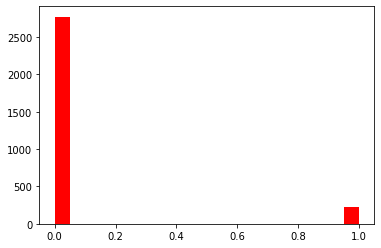

42:======================================================================
2_1 = 3.0
std_dev 0.10274419565226146
mean 0.0106702234078026
min 0.0
max 1.0


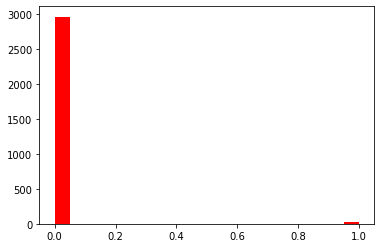

43:======================================================================
2_2 = -2.0
std_dev 0.38423743857394604
mean 0.1800600200066689
min 0.0
max 1.0


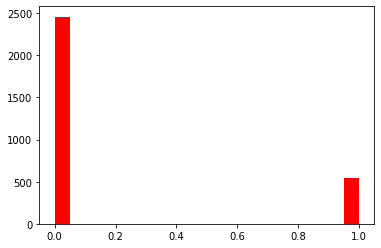

44:======================================================================
2_2 = -1.0
std_dev 0.3820004945230244
mean 0.17739246415471824
min 0.0
max 1.0


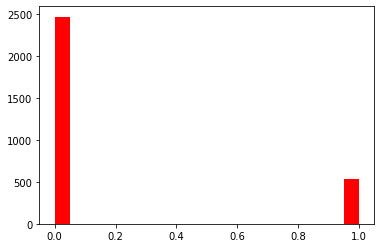

45:======================================================================
2_2 = 0.0
std_dev 0.4967190276677652
mean 0.5571857285761921
min 0.0
max 1.0


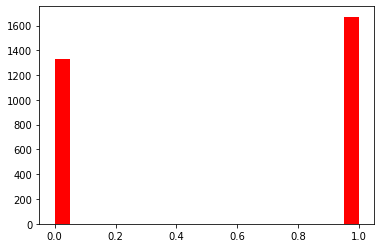

46:======================================================================
2_2 = 2.0
std_dev 0.2639688549934301
mean 0.07535845281760586
min 0.0
max 1.0


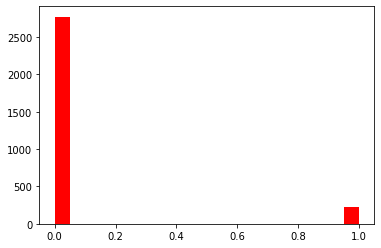

47:======================================================================
2_2 = 3.0
std_dev 0.09951516339131498
mean 0.010003334444814937
min 0.0
max 1.0


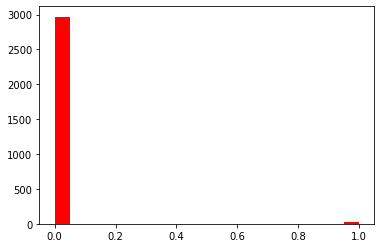

48:======================================================================
60290 < 1683.000000
std_dev 0.399799794260003
mean 0.19973324441480494
min 0.0
max 1.0


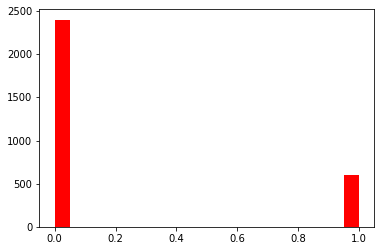

49:======================================================================
1683.000000 <=60290 < 11752.000000
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


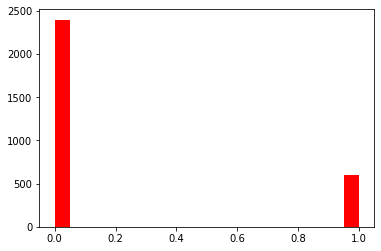

50:======================================================================
11752.000000 <=60290 < 37319.000000
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


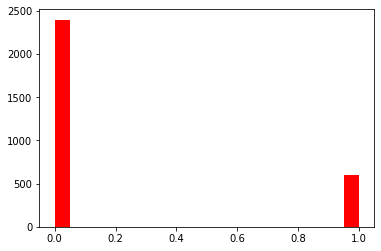

51:======================================================================
37319.000000 <=60290 < 84942.000000
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


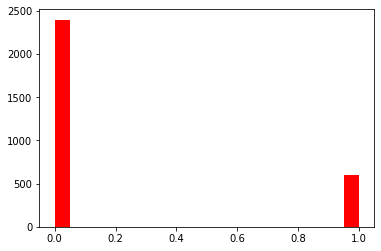

52:======================================================================
84942.000000 <=60290
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


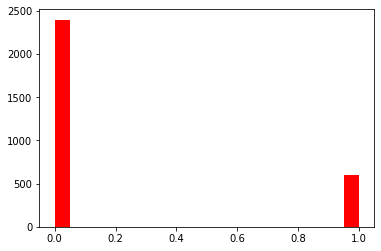

53:======================================================================
61688 < 1394.000000
std_dev 0.399799794260003
mean 0.19973324441480494
min 0.0
max 1.0


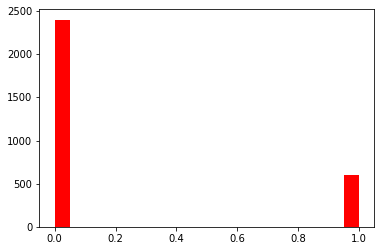

54:======================================================================
1394.000000 <=61688 < 10635.000000
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


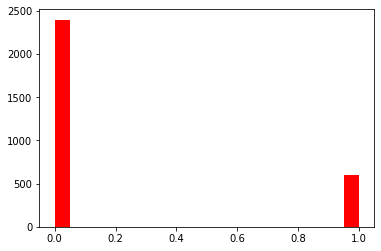

55:======================================================================
10635.000000 <=61688 < 34509.000000
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


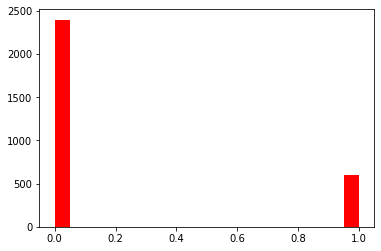

56:======================================================================
34509.000000 <=61688 < 82471.000000
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


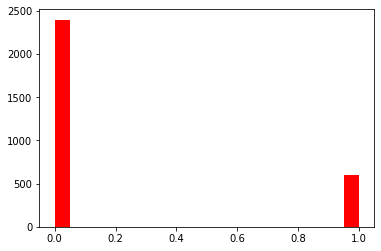

57:======================================================================
82471.000000 <=61688
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


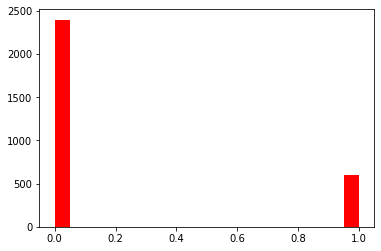

58:======================================================================
63100 < 1091.000000
std_dev 0.399799794260003
mean 0.19973324441480494
min 0.0
max 1.0


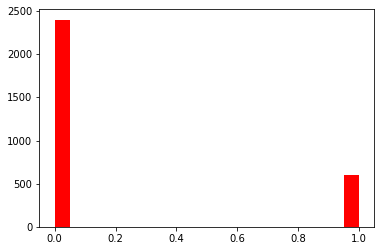

59:======================================================================
1091.000000 <=63100 < 10550.000000
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


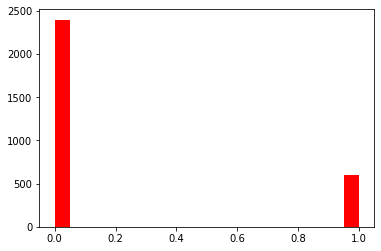

60:======================================================================
10550.000000 <=63100 < 32101.000000
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


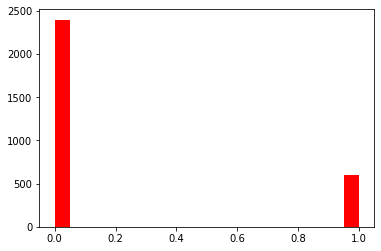

61:======================================================================
32101.000000 <=63100 < 77045.000000
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


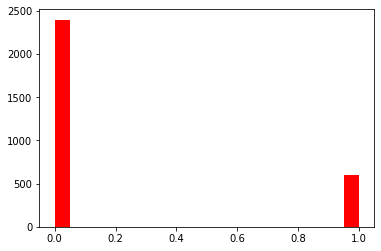

62:======================================================================
77045.000000 <=63100
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


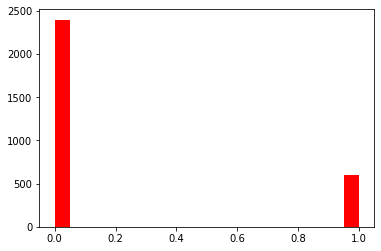

63:======================================================================
70391 < 827.000000
std_dev 0.3995491455626787
mean 0.1993997999333111
min 0.0
max 1.0


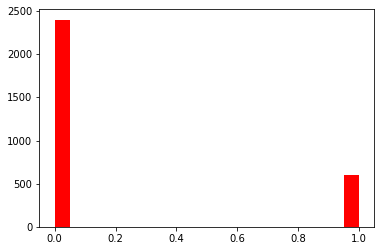

64:======================================================================
827.000000 <=70391 < 10990.000000
std_dev 0.4002997875592186
mean 0.2004001333777926
min 0.0
max 1.0


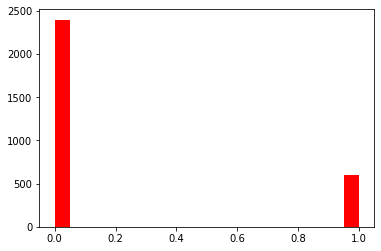

65:======================================================================
10990.000000 <=70391 < 29480.000000
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


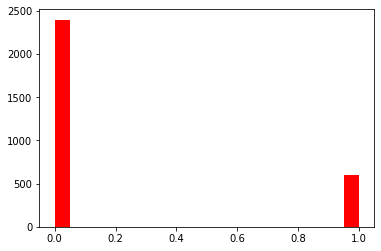

66:======================================================================
29480.000000 <=70391 < 74172.000000
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


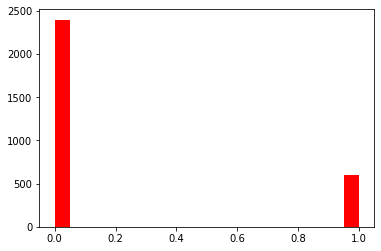

67:======================================================================
74172.000000 <=70391
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


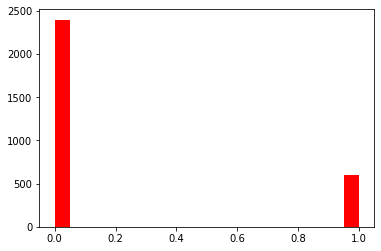

68:======================================================================
68661 < 772.000000
std_dev 0.399799794260003
mean 0.19973324441480494
min 0.0
max 1.0


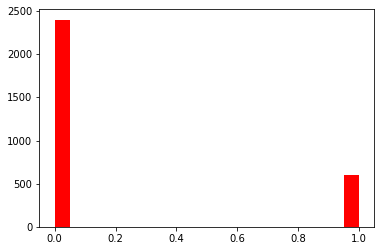

69:======================================================================
772.000000 <=68661 < 9390.000000
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


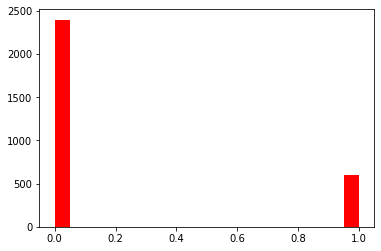

70:======================================================================
9390.000000 <=68661 < 24767.000000
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


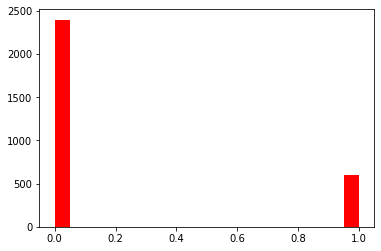

71:======================================================================
24767.000000 <=68661 < 67573.000000
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


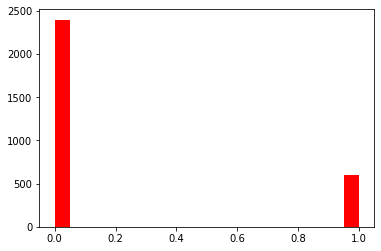

72:======================================================================
67573.000000 <=68661
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


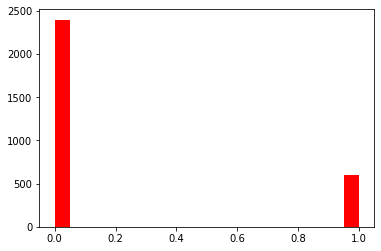

73:======================================================================
77511 < 440.000000
std_dev 0.39954914556267873
mean 0.1993997999333111
min 0.0
max 1.0


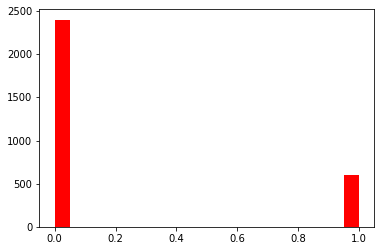

74:======================================================================
440.000000 <=77511 < 8274.000000
std_dev 0.4002997875592186
mean 0.2004001333777926
min 0.0
max 1.0


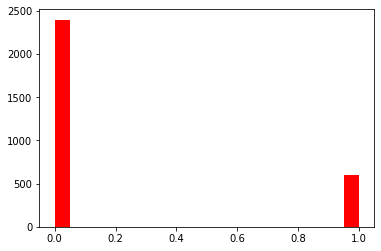

75:======================================================================
8274.000000 <=77511 < 22970.000000
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


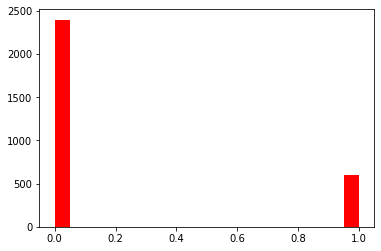

76:======================================================================
22970.000000 <=77511 < 63421.000000
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


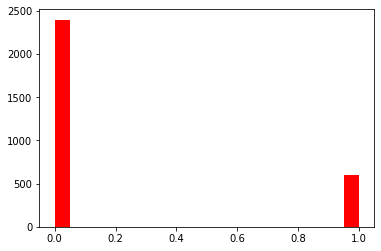

77:======================================================================
63421.000000 <=77511
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


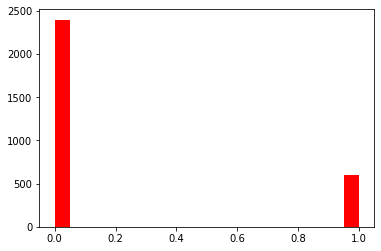

78:======================================================================
60290/110000 < 0.009786
std_dev 0.399799794260003
mean 0.19973324441480494
min 0.0
max 1.0


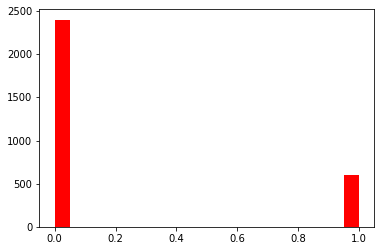

79:======================================================================
0.009786 <=60290/110000 < 0.123220
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


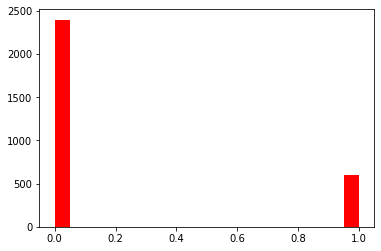

80:======================================================================
0.123220 <=60290/110000 < 0.525008
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


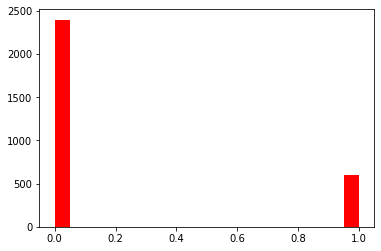

81:======================================================================
0.525008 <=60290/110000 < 0.915500
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


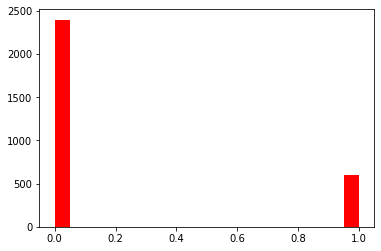

82:======================================================================
0.915500 <=60290/110000
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


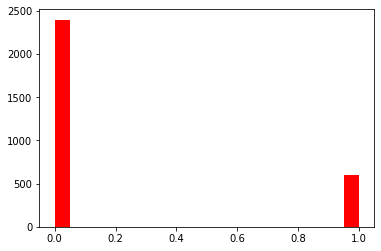

83:======================================================================
61688/110000 < 0.008087
std_dev 0.39979979426000295
mean 0.19973324441480494
min 0.0
max 1.0


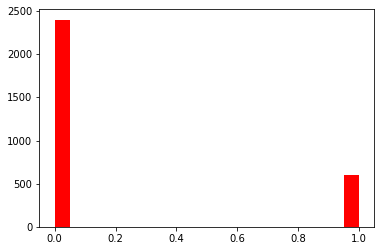

84:======================================================================
0.008087 <=61688/110000 < 0.108200
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


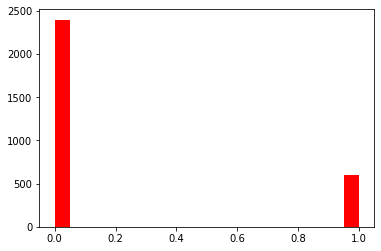

85:======================================================================
0.108200 <=61688/110000 < 0.500875
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


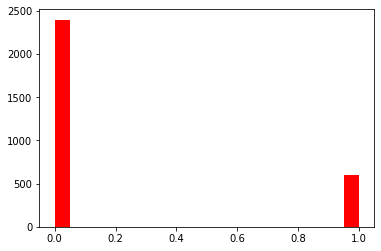

86:======================================================================
0.500875 <=61688/110000 < 0.896263
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


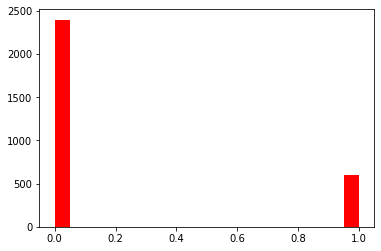

87:======================================================================
0.896263 <=61688/110000
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


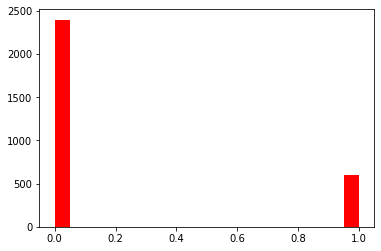

88:======================================================================
63100/110000 < 0.006285
std_dev 0.399799794260003
mean 0.19973324441480494
min 0.0
max 1.0


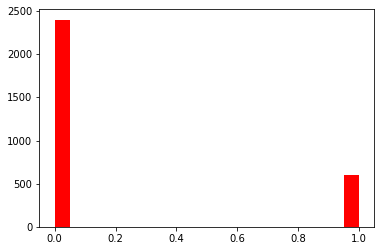

89:======================================================================
0.006285 <=63100/110000 < 0.100225
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


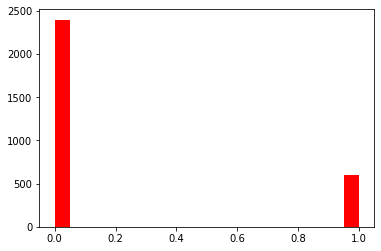

90:======================================================================
0.100225 <=63100/110000 < 0.468500
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


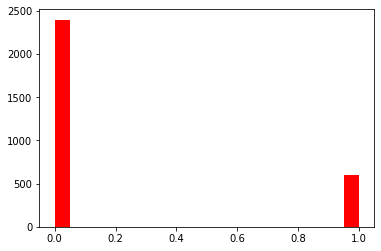

91:======================================================================
0.468500 <=63100/110000 < 0.872874
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


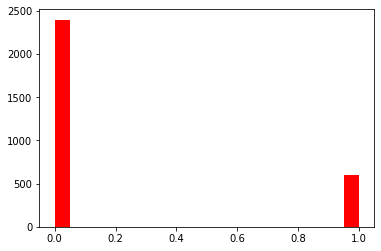

92:======================================================================
0.872874 <=63100/110000
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


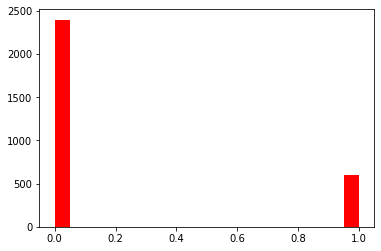

93:======================================================================
70391/110000 < 0.005433
std_dev 0.399799794260003
mean 0.19973324441480494
min 0.0
max 1.0


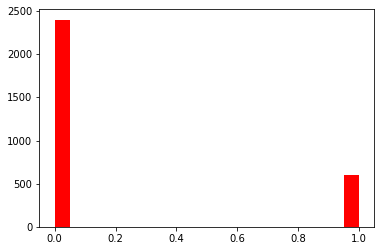

94:======================================================================
0.005433 <=70391/110000 < 0.097083
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


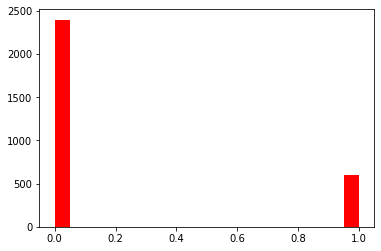

95:======================================================================
0.097083 <=70391/110000 < 0.410400
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


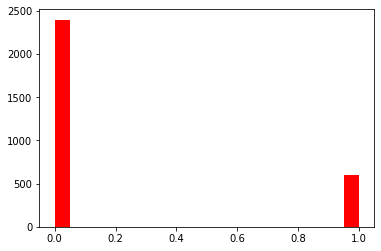

96:======================================================================
0.410400 <=70391/110000 < 0.808300
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


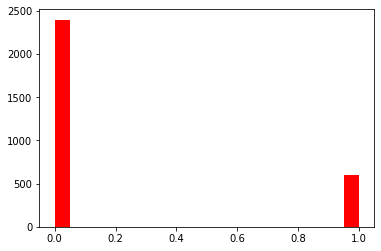

97:======================================================================
0.808300 <=70391/110000
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


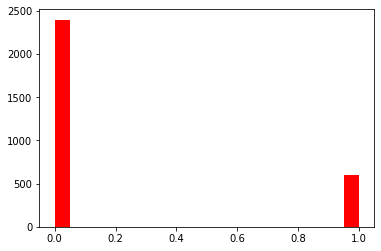

98:======================================================================
68661/110000 < 0.004592
std_dev 0.399799794260003
mean 0.19973324441480494
min 0.0
max 1.0


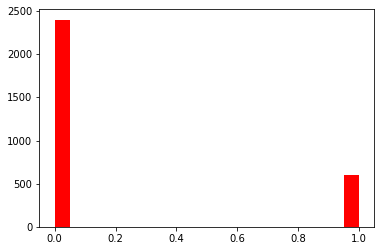

99:======================================================================
0.004592 <=68661/110000 < 0.078190
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


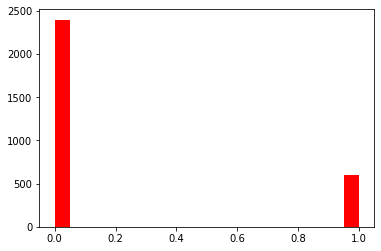

100:======================================================================
0.078190 <=68661/110000 < 0.358522
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


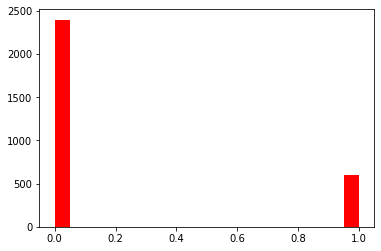

101:======================================================================
0.358522 <=68661/110000 < 0.696008
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


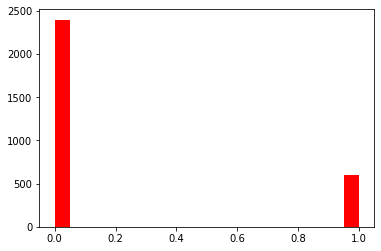

102:======================================================================
0.696008 <=68661/110000
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


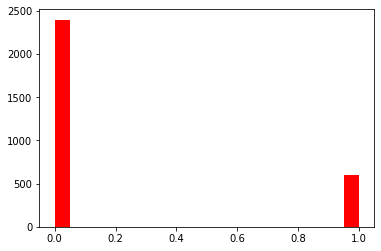

103:======================================================================
77511/110000 < 0.002790
std_dev 0.39979979426000295
mean 0.19973324441480494
min 0.0
max 1.0


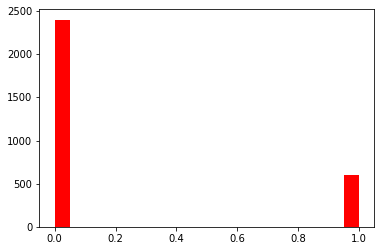

104:======================================================================
0.002790 <=77511/110000 < 0.060000
std_dev 0.399799794260003
mean 0.19973324441480494
min 0.0
max 1.0


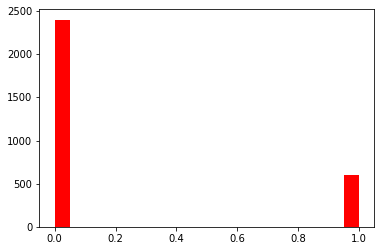

105:======================================================================
0.060000 <=77511/110000 < 0.333420
std_dev 0.4002997875592186
mean 0.2004001333777926
min 0.0
max 1.0


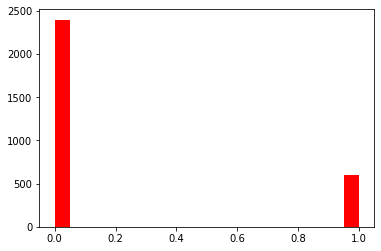

106:======================================================================
0.333420 <=77511/110000 < 0.670930
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


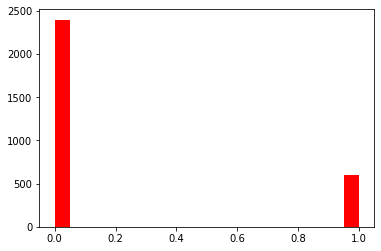

107:======================================================================
0.670930 <=77511/110000
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


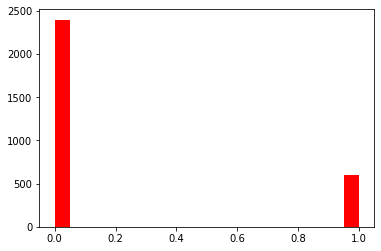

108:======================================================================
3000 < 350.000000
std_dev 0.39979979426000295
mean 0.19973324441480494
min 0.0
max 1.0


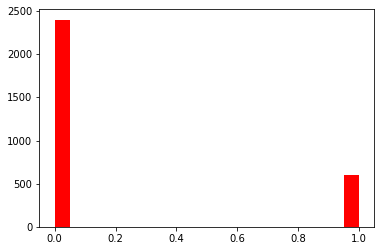

109:======================================================================
350.000000 <=3000 < 1747.000000
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


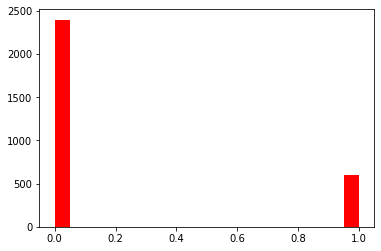

110:======================================================================
1747.000000 <=3000 < 3000.000000
std_dev 0.3742117740704625
mean 0.1683894631543848
min 0.0
max 1.0


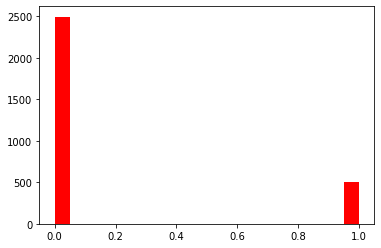

111:======================================================================
3000.000000 <=3000 < 6300.000000
std_dev 0.42130865280886787
mean 0.23074358119373126
min 0.0
max 1.0


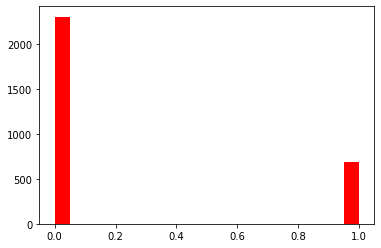

112:======================================================================
6300.000000 <=3000
std_dev 0.4007980474850052
mean 0.20106702234078025
min 0.0
max 1.0


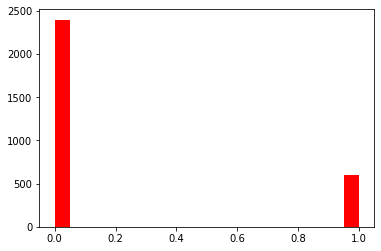

113:======================================================================
3000_1 < 264.000000
std_dev 0.399799794260003
mean 0.19973324441480494
min 0.0
max 1.0


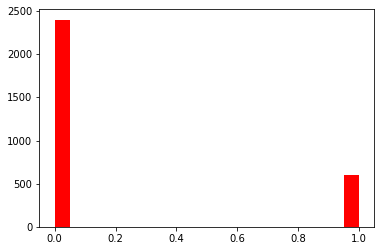

114:======================================================================
264.000000 <=3000_1 < 1680.000000
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


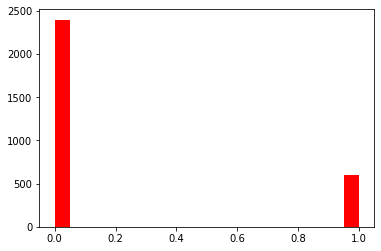

115:======================================================================
1680.000000 <=3000_1 < 3000.000000
std_dev 0.38534411634825216
mean 0.1813937979326442
min 0.0
max 1.0


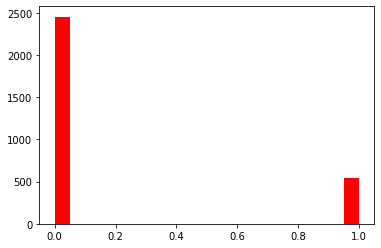

116:======================================================================
3000.000000 <=3000_1 < 6100.000000
std_dev 0.41270917967243503
mean 0.21773924641547182
min 0.0
max 1.0


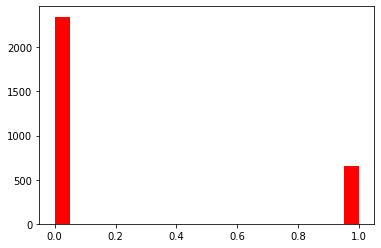

117:======================================================================
6100.000000 <=3000_1
std_dev 0.4007980474850052
mean 0.20106702234078025
min 0.0
max 1.0


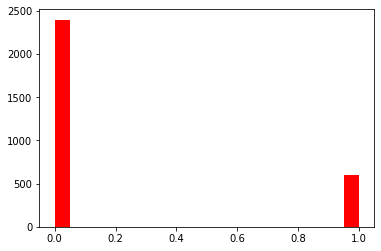

118:======================================================================
9000 < 7.000000
std_dev 0.399799794260003
mean 0.19973324441480494
min 0.0
max 1.0


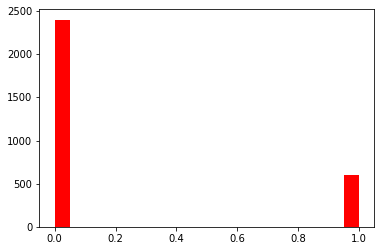

119:======================================================================
7.000000 <=9000 < 1496.000000
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


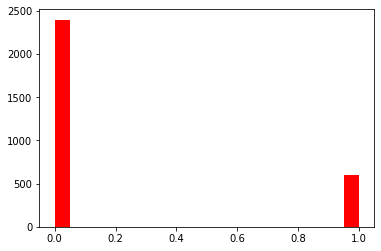

120:======================================================================
1496.000000 <=9000 < 2700.000000
std_dev 0.39929806107586846
mean 0.19906635545181728
min 0.0
max 1.0


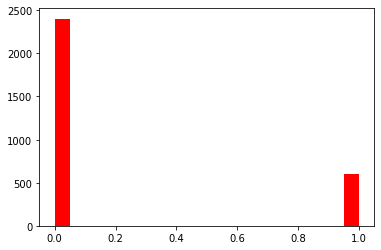

121:======================================================================
2700.000000 <=9000 < 6000.000000
std_dev 0.39854218463485813
mean 0.19806602200733578
min 0.0
max 1.0


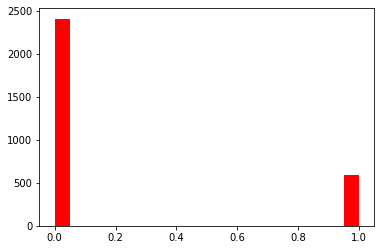

122:======================================================================
6000.000000 <=9000
std_dev 0.40228249131752636
mean 0.20306768922974325
min 0.0
max 1.0


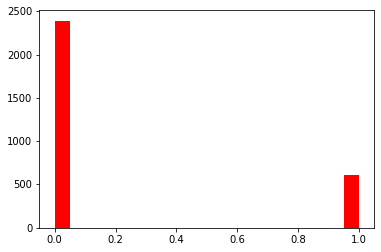

123:======================================================================
0_4 < 0.000000
std_dev 0.0
mean 0.0
min 0.0
max 0.0


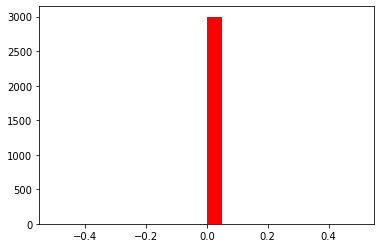

124:======================================================================
0.000000 <=0_4 < 1000.000000
std_dev 0.4863884142401412
mean 0.3841280426808936
min 0.0
max 1.0


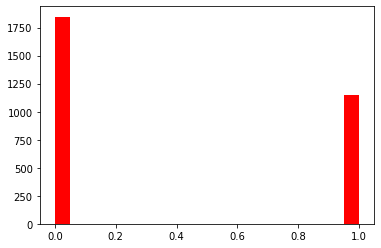

125:======================================================================
1000.000000 <=0_4 < 2200.000000
std_dev 0.4111031048791214
mean 0.21540513504501502
min 0.0
max 1.0


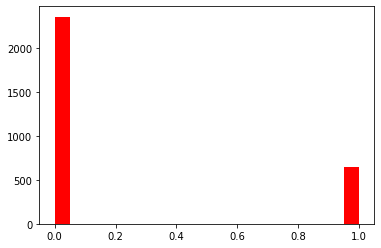

126:======================================================================
2200.000000 <=0_4 < 5000.000000
std_dev 0.3845148403613581
mean 0.1803934644881627
min 0.0
max 1.0


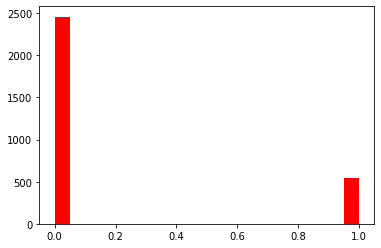

127:======================================================================
5000.000000 <=0_4
std_dev 0.41429587854425404
mean 0.22007335778592865
min 0.0
max 1.0


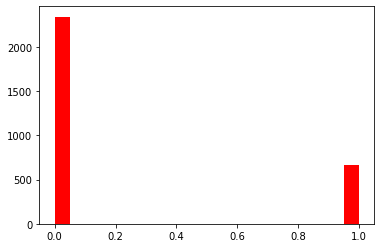

128:======================================================================
10000 < 0.000000
std_dev 0.0
mean 0.0
min 0.0
max 0.0


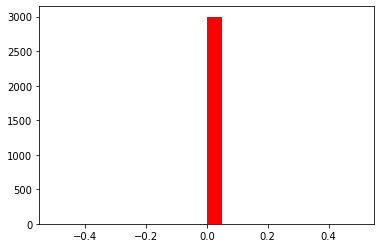

129:======================================================================
0.000000 <=10000 < 1000.000000
std_dev 0.48844552017122256
mean 0.3931310436812271
min 0.0
max 1.0


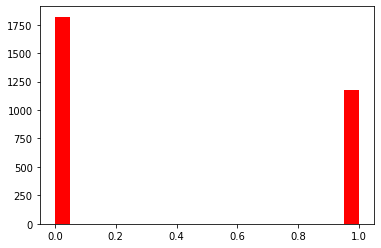

130:======================================================================
1000.000000 <=10000 < 2100.000000
std_dev 0.4047224890050995
mean 0.20640213404468155
min 0.0
max 1.0


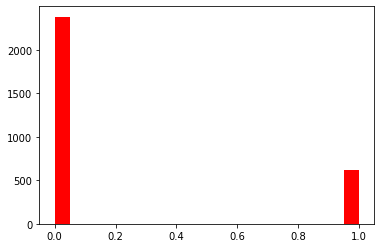

131:======================================================================
2100.000000 <=10000 < 5000.000000
std_dev 0.3853441163482521
mean 0.1813937979326442
min 0.0
max 1.0


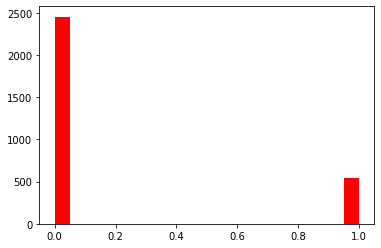

132:======================================================================
5000.000000 <=10000
std_dev 0.41361822293914813
mean 0.21907302434144715
min 0.0
max 1.0


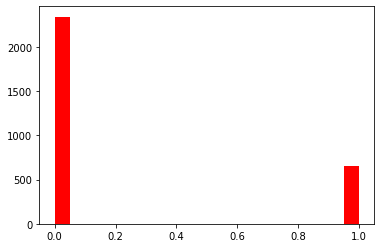

133:======================================================================
3000_2 < 0.000000
std_dev 0.0
mean 0.0
min 0.0
max 0.0


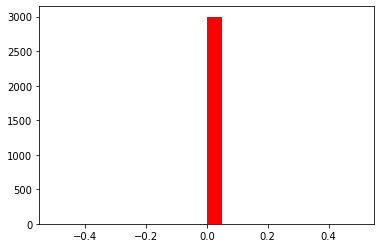

134:======================================================================
0.000000 <=3000_2 < 1000.000000
std_dev 0.4862290584768031
mean 0.38346115371790596
min 0.0
max 1.0


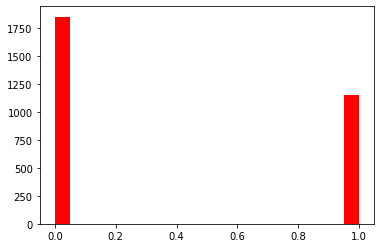

135:======================================================================
1000.000000 <=3000_2 < 2300.000000
std_dev 0.4108720707004434
mean 0.21507169056352118
min 0.0
max 1.0


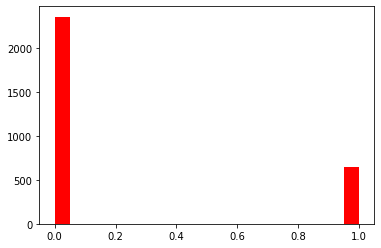

136:======================================================================
2300.000000 <=3000_2 < 5000.000000
std_dev 0.3834022889999988
mean 0.1790596865621874
min 0.0
max 1.0


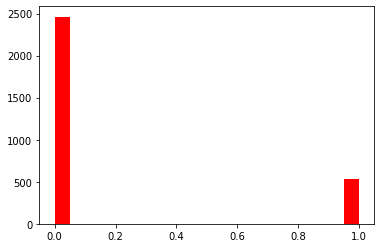

137:======================================================================
5000.000000 <=3000_2
std_dev 0.4158634232772064
mean 0.22240746915638546
min 0.0
max 1.0


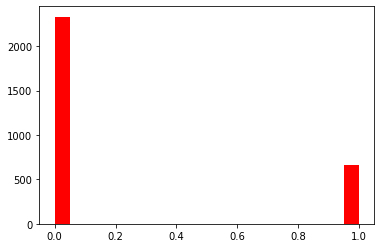

138:======================================================================
3000/110000 < 0.001756
std_dev 0.39979979426000295
mean 0.19973324441480494
min 0.0
max 1.0


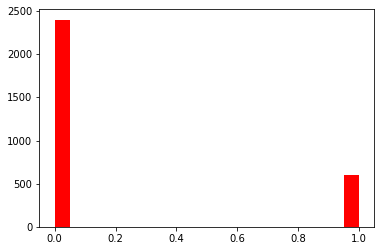

139:======================================================================
0.001756 <=3000/110000 < 0.016667
std_dev 0.3992980610758685
mean 0.19906635545181728
min 0.0
max 1.0


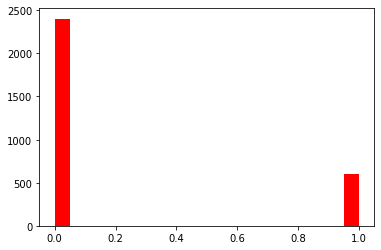

140:======================================================================
0.016667 <=3000/110000 < 0.033333
std_dev 0.39803607288496834
mean 0.1973991330443481
min 0.0
max 1.0


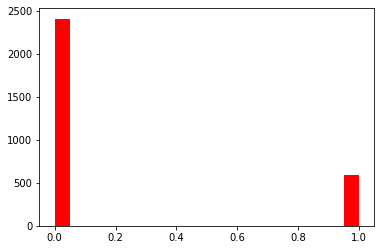

141:======================================================================
0.033333 <=3000/110000 < 0.050425
std_dev 0.40277388177656326
mean 0.20373457819273091
min 0.0
max 1.0


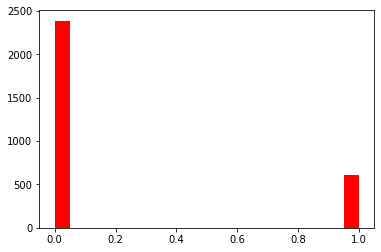

142:======================================================================
0.050425 <=3000/110000
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


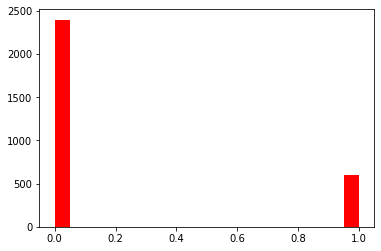

143:======================================================================
3000_1/110000 < 0.000948
std_dev 0.39979979426000295
mean 0.19973324441480494
min 0.0
max 1.0


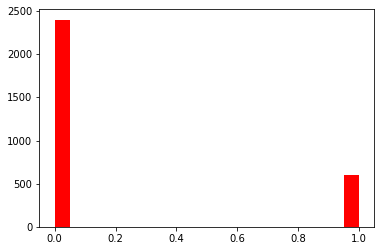

144:======================================================================
0.000948 <=3000_1/110000 < 0.015455
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


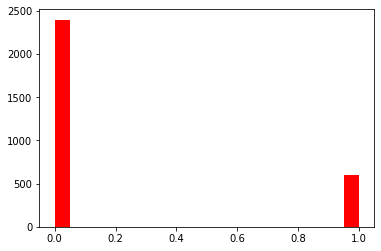

145:======================================================================
0.015455 <=3000_1/110000 < 0.032917
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


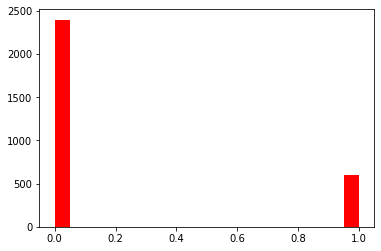

146:======================================================================
0.032917 <=3000_1/110000 < 0.051443
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


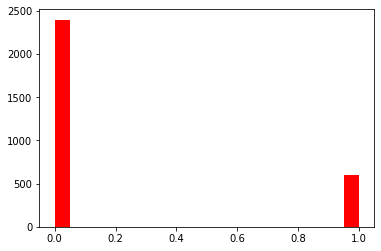

147:======================================================================
0.051443 <=3000_1/110000
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


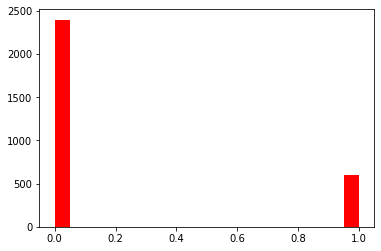

148:======================================================================
9000/110000 < 0.000037
std_dev 0.399799794260003
mean 0.19973324441480494
min 0.0
max 1.0


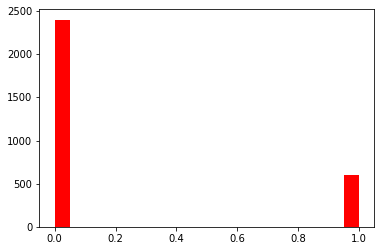

149:======================================================================
0.000037 <=9000/110000 < 0.013333
std_dev 0.39904653997696177
mean 0.19873291097032345
min 0.0
max 1.0


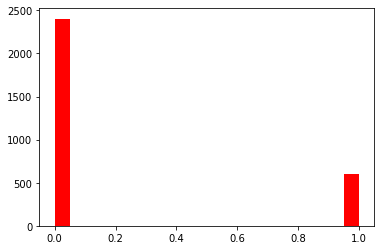

150:======================================================================
0.013333 <=9000/110000 < 0.028489
std_dev 0.40104652945268604
mean 0.20140046682227408
min 0.0
max 1.0


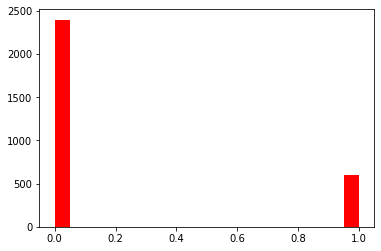

151:======================================================================
0.028489 <=9000/110000 < 0.048287
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


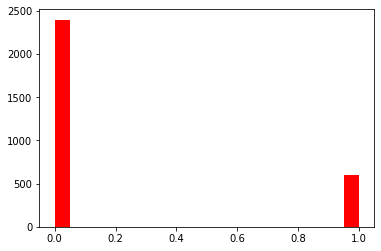

152:======================================================================
0.048287 <=9000/110000
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


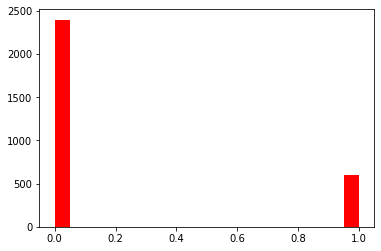

153:======================================================================
0_4/110000 < 0.000000
std_dev 0.0
mean 0.0
min 0.0
max 0.0


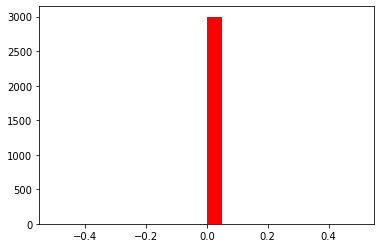

154:======================================================================
0.000000 <=0_4/110000 < 0.010000
std_dev 0.48829913165961825
mean 0.3924641547182394
min 0.0
max 1.0


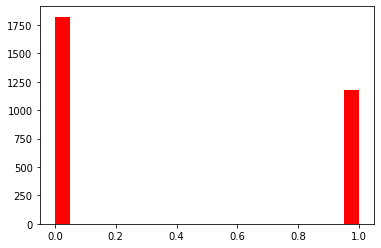

155:======================================================================
0.010000 <=0_4/110000 < 0.021300
std_dev 0.4054462775369503
mean 0.20740246748916305
min 0.0
max 1.0


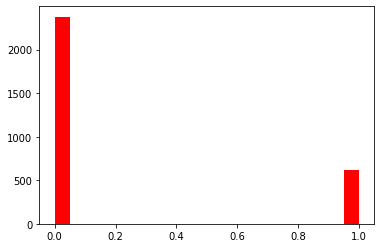

156:======================================================================
0.021300 <=0_4/110000 < 0.037368
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


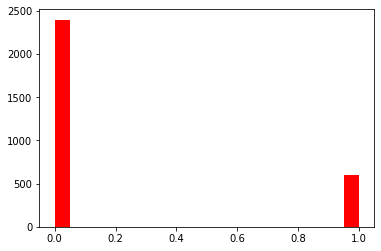

157:======================================================================
0.037368 <=0_4/110000
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


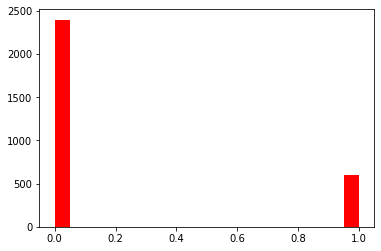

158:======================================================================
10000/110000 < 0.000000
std_dev 0.0
mean 0.0
min 0.0
max 0.0


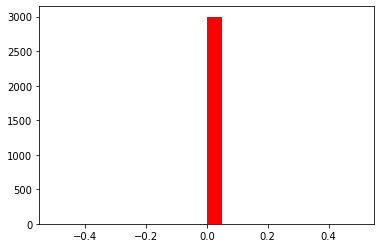

159:======================================================================
0.000000 <=10000/110000 < 0.009400
std_dev 0.48985706755699737
mean 0.3997999333111037
min 0.0
max 1.0


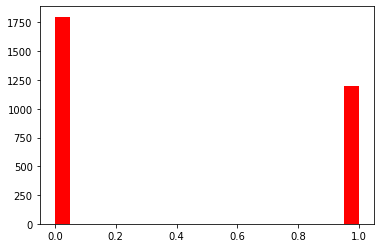

160:======================================================================
0.009400 <=10000/110000 < 0.021150
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


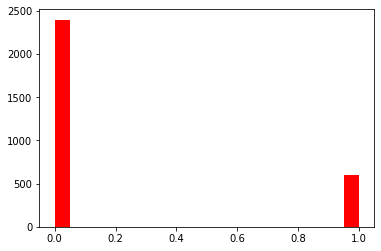

161:======================================================================
0.021150 <=10000/110000 < 0.037988
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


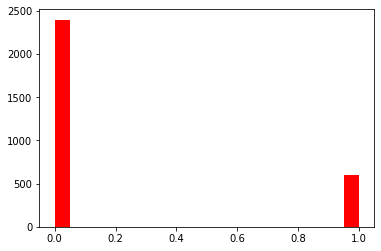

162:======================================================================
0.037988 <=10000/110000
std_dev 0.4000500079869645
mean 0.20006668889629878
min 0.0
max 1.0


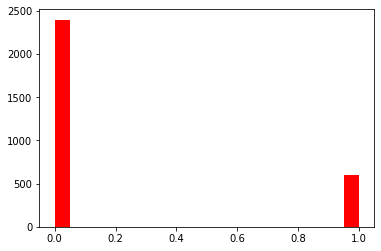

163:======================================================================
3000_2/110000 < 0.000000
std_dev 0.0
mean 0.0
min 0.0
max 0.0


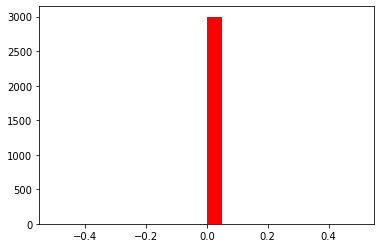

164:======================================================================
0.000000 <=3000_2/110000 < 0.009524
std_dev 0.4897201826119901
mean 0.39913304434811603
min 0.0
max 1.0


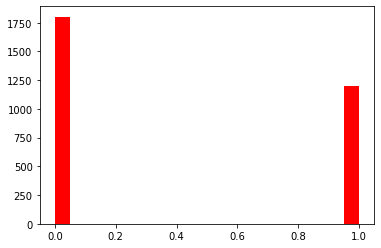

165:======================================================================
0.009524 <=3000_2/110000 < 0.021655
std_dev 0.4005491337889725
mean 0.20073357785928642
min 0.0
max 1.0


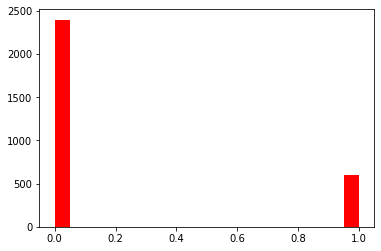

166:======================================================================
0.021655 <=3000_2/110000 < 0.039130
std_dev 0.39979979426000295
mean 0.19973324441480494
min 0.0
max 1.0


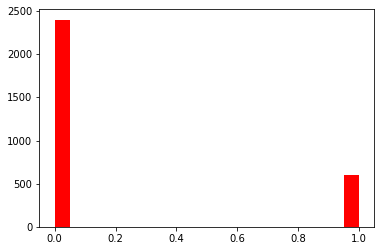

167:======================================================================
0.039130 <=3000_2/110000
std_dev 0.4002997875592186
mean 0.2004001333777926
min 0.0
max 1.0


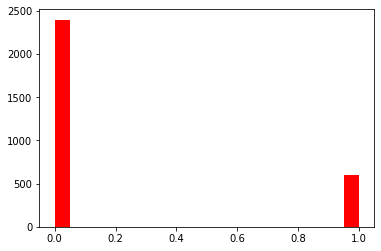

In [8]:
analyze(nf, nd)

In [9]:
save_to_csv(nd, nf, correct_answers, 'ccard_preprocessed.csv')
print("ok")

ok


In [18]:
print(1 - np.mean(correct_answers))

0.7789263087695899


In [19]:
print(nf.shape)

(2999, 168)


In [20]:
print(np.max(nf[:, 1]))
print(np.min(nf[:, 1]))
f = (nf[:, 1] - np.min(nf[:, 1]))/(np.max(nf[:, 1]) - np.min(nf[:, 1]))
print(f)

1.0
0.0
[0.36941599185480056 0.15909880786929378 0.10788043175308164 ...
 0.2521656443822711  0.4772964236078822  0.36941599185480056]
